# Part 1.  A guide for how to use the lstmstock.py

This is a presentation of the simplest way to implement Long Short Term Memory for prediction of stock price. More codes are in the lstmstock.py file. It also fixed the problem of using pandas datareader to download stock data, which is currently unavailable.

# 1. Import all the module and function
You can import all module one by one or import my lstmstock.py

In [1]:
# from lstmstock import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
from keras import backend as K
import quandl

Using TensorFlow backend.


# 2. Input of the model

1. Quandl api key Obtained from https://www.quandl.com/product/WIKIP/WIKI/PRICES-Quandl-End-Of-Day-Stocks-Info Please login to use your key if you have one.

2. Seq_len
It is the window frame of the past data, how many days of past data would you like to be included in this model?

3. Shape
Please input the [seq_len, Amount of features, 1] to it to setup the model
The amount of features will depend on how many moving average would you like to be included in this model.

4. Dropout
Fraction of the input units to drop. It helps to avoid overfitting.

5. Decay
Weight regularization. Another parameter to avoid overfitting.

6. Epochs
How many Epochs would you want to fit the model?

In [2]:
quandl.ApiConfig.api_key = 'zpFWg7jpwtBPmzA8sT2Z'
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 10
stock_name = 'FLWS'

# 3. Pull the data from Quandl first

If you would like to include moving average, simply put the number of days into a list. 
They will be included into the neural network model.

ie. putting 50days, 100days, 200days into [50, 100, 200]

In the Quandl database, Open, High, Low, Close, Volume are all adjusted. 

In [3]:
def get_stock_data(stock_name, normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = quandl.get_table('WIKI/PRICES', ticker = stock_name)
    df.drop(['ticker', 'open', 'high', 'low', 'close', 'ex-dividend', 'volume', 'split_ratio'], 1, inplace=True)
    df.set_index('date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'adj_open': 'Open', 'adj_high': 'High', 'adj_low': 'Low', 'adj_volume': 'Volume', 'adj_close': 'Adj Close'}, inplace=True)
    
    # Percentage change
    df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
        df['Pct'] = min_max_scaler.fit_transform(df['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
                
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df = get_stock_data(stock_name, ma=[50, 100, 200])

# 4. Visualize the data
Print out the first 5 rows of the dataframe and plot out the Adjusted Close price and percentage change of that particular stock 

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

                Open      High       Low    Volume       Pct      50ma  \
date                                                                     
2000-05-17  0.373887  0.360843  0.375802  0.031033  0.363142  0.381950   
2000-05-18  0.364629  0.353313  0.375802  0.025009  0.389492  0.381254   
2000-05-19  0.355371  0.345783  0.375802  0.035487  0.389590  0.380957   
2000-05-22  0.357211  0.360843  0.375802  0.027419  0.445512  0.381106   
2000-05-23  0.357211  0.345783  0.371914  0.058014  0.376025  0.380709   

               100ma     200ma  Adj Close  
date                                       
2000-05-17  0.558310  0.885206   0.373895  
2000-05-18  0.554386  0.880531   0.370079  
2000-05-19  0.551045  0.876294   0.366323  
2000-05-22  0.547599  0.871677   0.377650  
2000-05-23  0.544370  0.867469   0.370079  


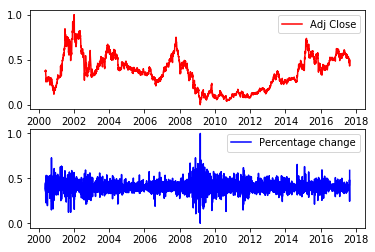

In [6]:
plot_stock(df)

# 5. To see the correlation for each variables
Not so ideal but more fundamental data will be included in the future

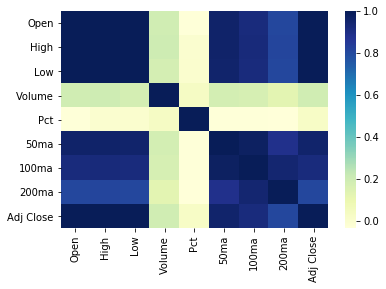

In [7]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

# 6. Split out training set and testing set data

In [8]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    
    pRow = round(0.99 * train.shape[0])
    pTrain =  result[:int(pRow), :]
    left_X_train = pTrain[:, :-1] # all data until day m
    left_y_train = pTrain[:, -1][:,-1] # day m + 1 adjusted close price
    right_X_test = train[int(pRow):, :-1]
    right_y_test = train[int(pRow):, -1][:,-1] 
    
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    print("left_X_train: " + str(len(left_X_train)))
    print("right_X_test: " + str(len(right_X_test)))
    return [left_X_train, left_y_train, right_X_test, right_y_test]

In [9]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

left_X_train: 3852
right_X_test: 39


# 7. Model Execution

In [10]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = build_model(shape, neurons, dropout, decay)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 256)           272384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 805,953
Trainable params: 805,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.2,
    verbose=1)

Train on 3081 samples, validate on 771 samples
Epoch 1/10
3081/3081 [==============================] - 16s - loss: 0.0898 - acc: 3.2457e-04 - val_loss: 0.0285 - val_acc: 0.0000e+00
Epoch 2/10
3081/3081 [==============================] - 17s - loss: 0.0239 - acc: 3.2457e-04 - val_loss: 0.0123 - val_acc: 0.0000e+00
Epoch 3/10
 512/3081 [===>..........................] - ETA: 13s - loss: 0.0159 - acc: 0.0000e+00

# 8. Result on training set and testing set

In [ ]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [ ]:
model_score(model, X_train, y_train, X_test, y_test)

# 9. Prediction vs Real results

In [ ]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [ ]:
def denormalize(stock_name, normalized_value):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = quandl.get_table('WIKI/PRICES', ticker = stock_name)
    df.drop(['ticker', 'open', 'high', 'low', 'close', 'ex-dividend', 'volume', 'split_ratio'], 1, inplace=True)
    df.set_index('date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'adj_open': 'Open', 'adj_high': 'High', 'adj_low': 'Low', 'adj_volume': 'Volume', 'adj_close': 'Adj Close'}, inplace=True)
    
    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
      
    return new

In [ ]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    print(newp)
    print(normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

In [ ]:
p = percentage_difference(model, X_test, y_test)

In [ ]:
plot_result(stock_name, p, y_test)

# Part 2. Finding the best hyperparameter

In [ ]:
def quick_measure(stock_name, seq_len, dropout, shape, neurons, epochs, decay):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model(shape, neurons, dropout, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.2, verbose=0)
    # model.save('LSTM_Stock_prediction-20170528.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [ ]:
quandl.ApiConfig.api_key = 'zpFWg7jpwtBPmzA8sT2Z'
seq_len = 22
shape = [seq_len, 6, 1] # Without moving average, 6 features will be used
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 80
stock_name = 'AAPL'

# 1. Testing for epochs
Repeatedly test it and sum up the result

In [ ]:
epochslist = [40,50,60,70,80,90,100,110,120,130,140,150]
epochs_train_result = {}
epochs_test_result = {}
#i=0

#for epochs in epochslist:   
#    epochs_train_result[epochs] = 0
#    epochs_test_result[epochs] = 0

# while i < 5:
for epochs in epochslist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    epochs_train_result[epochs] = trainScore
    epochs_test_result[epochs] = testScore
#    i+=1

In [ ]:
# epochs_train_result

In [ ]:
min_train_val = min(epochs_train_result.values())
min_train_val_key = [k for k, v in epochs_train_result.items() if v == min_train_val]
print (epochs_train_result)
print (min_train_val_key)

In [ ]:
min_test_val = min(epochs_test_result.values())
min_test_val_key = [k for k, v in epochs_test_result.items() if v == min_test_val]
print (epochs_test_result)
print (min_test_val_key)

In [ ]:
lists1 = sorted(epochs_test_result.items())
x1,y1 = zip(*lists1)
plt.plot(x1,y1)

plt.title('Finding the best hyperparameter for testing')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

In [ ]:
lists2 = sorted(epochs_train_result.items())
x2,y2 = zip(*lists2)
plt.plot(x2,y2)
plt.title('Finding the best hyperparameter for training set')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

# 2. Testing for dropout

In [ ]:
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
dropout_train_result = {}
dropout_test_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    dropout_train_result[d] = trainScore
    dropout_test_result[d] = testScore

In [ ]:
min_train_val = min(dropout_train_result.values())
min_train_val_key = [k for k, v in dropout_train_result.items() if v == min_train_val]
print (dropout_train_result)
print (min_train_val_key)

In [ ]:
min_test_val = min(dropout_test_result.values())
min_test_val_key = [k for k, v in dropout_test_result.items() if v == min_test_val]
print (dropout_test_result)
print (min_test_val_key)

In [ ]:
lists1 = sorted(dropout_test_result.items())
x1,y1 = zip(*lists1)
plt.plot(x1,y1)
plt.title('Finding the best hyperparameter for testing set')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

In [ ]:
lists2 = sorted(dropout_train_result.items())
x2,y2 = zip(*lists2)
plt.plot(x2,y2)
plt.title('Finding the best hyperparameter for training set')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()